Things I read:
https://mc-stan.org/users/documentation/case-studies/pystan_workflow.html
https://pystan.readthedocs.io/en/latest/getting_started.html


In [1]:
import pystan
import numpy as np

ocode = """
data {
    int<lower=1> N;
    real y[N];
}
parameters {
    real mu;
}
model {
    y ~ normal(mu, 1);
}
"""
sm = pystan.StanModel(model_code=ocode)
y2 = np.random.normal(size=20)
print(np.mean(y2))

op = sm.optimizing(data=dict(y=y2, N=len(y2)))

op

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3aaa1aff3be33470f8a5bfa56085d51c NOW.


-0.03395900129120494


OrderedDict([('mu', array(-0.033959))])

['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)']


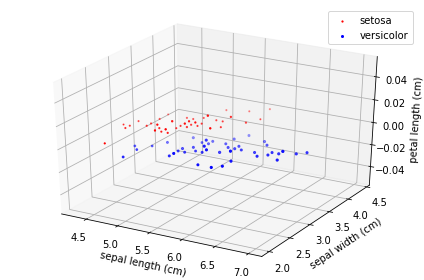

In [83]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
x = np.delete(iris['data'], 3, 1)
y = iris['target']
names = iris['target_names']
feature_names = np.delete(iris['feature_names'], 3)
# removed some features to speed up optimization and make it 3d graphable :)

fig1 = plt.figure(1)
ax = fig1.add_subplot(111, projection='3d')

scatter_0 = plt.scatter(x[:,0][0:50], x[:,1][0:50], x[:,2][0:50], c="r", marker="o", label=names[0])
scatter_1 = plt.scatter(x[:,0][50:100], x[:,1][50:100], x[:,2][50:100], c="b", marker="o", label=names[1])
# scatter_2 = plt.scatter(x[:,0][100:150], x[:,1][100:150], x[:,2][100:150], c="b", marker="*", label=names[2])

plt.legend(handles=[scatter_0, scatter_1])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])

print(feature_names)

fig1.tight_layout()

fig1.show()

In [49]:
ocode = """
data {
    int N;
    
    vector[N] setosa_sepal_length;
    vector[N] setosa_sepal_width;
    vector[N] setosa_petal_length;
    
    vector[N] versicolor_sepal_length;
    vector[N] versicolor_sepal_width;
    vector[N] versicolor_petal_length;
}
parameters {
    real mu0;
    real mu1;
    real mu2;
    real mu3;
    real mu4;
    real mu5;
    real sigma0;
    real sigma1;
    real sigma2;
    real sigma3;
    real sigma4;
    real sigma5;
}
model {
    setosa_sepal_length ~ normal(mu0, sigma0);
    setosa_sepal_width ~ normal(mu1, sigma1);
    setosa_petal_length ~ normal(mu2, sigma2);
    
    versicolor_sepal_length ~ normal(mu3, sigma3);
    versicolor_sepal_width ~ normal(mu4, sigma4);
    versicolor_petal_length ~ normal(mu5, sigma5);
}
"""
sm = pystan.StanModel(model_code=ocode)
sm

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ea364aae22bb30c414b3eef89b0efd5 NOW.


In [50]:
input_data = {'N': 50,
              'setosa_sepal_length': x[:,0][0:50],
              'setosa_sepal_width': x[:,1][0:50],
              'setosa_petal_length': x[:,2][0:50],
              'versicolor_sepal_length': x[:,0][50:100],
              'versicolor_sepal_width': x[:,1][50:100],
              'versicolor_petal_length': x[:,2][50:100]}

In [112]:
fit = sm.optimizing(data=input_data)

In [52]:
fit

OrderedDict([('mu0', array(5.00600345)),
             ('mu1', array(3.42800521)),
             ('mu2', array(1.46200558)),
             ('mu3', array(5.93599034)),
             ('mu4', array(2.77000744)),
             ('mu5', array(4.26001459)),
             ('sigma0', array(0.348944)),
             ('sigma1', array(0.37524762)),
             ('sigma2', array(0.17191545)),
             ('sigma3', array(0.51097067)),
             ('sigma4', array(0.3106411)),
             ('sigma5', array(0.46517892))])

In [73]:
dists = []
mu = []
sigma = []
for key, value in fit.items():
    if "mu" in key:
        mu.append(value.tolist())
    else:
        sigma.append(value.tolist())
params = dict(zip(mu, sigma))
for key, value in params.items():
    dists.append(np.random.normal(key, value, 50))

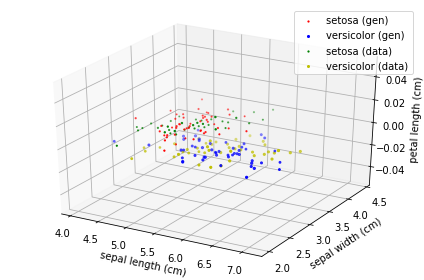

In [88]:
# if i were doing this more i would make a function to do this
fig2 = plt.figure(2)
ax = fig2.add_subplot(111, projection='3d')

scatter_0 = plt.scatter(dists[0], dists[1], dists[2], c="r", marker="o", label=names[0] + " (gen)")
scatter_1 = plt.scatter(dists[3], dists[4], dists[5], c="b", marker="o", label=names[1] + " (gen)")
scatter_2 = plt.scatter(x[:,0][0:50], x[:,1][0:50], x[:,2][0:50], c="g", marker="o", label=names[0] + " (data)")
scatter_3 = plt.scatter(x[:,0][50:100], x[:,1][50:100], x[:,2][50:100], c="y", marker="o", label=names[1] + " (data)")


plt.legend(handles=[scatter_0, scatter_1, scatter_2, scatter_3])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
fig2.tight_layout()
fig2.show()

In [120]:
# to validate: use it as a classifier and then see how well it does

def predict(x): # x = [sepal_length, sepal_width, petal_length] 
    # see how well it fits in setosa
    # (data value - mean) / stddev for each
    setosa_fit = 0
    for i in range (0, 3):
        setosa_fit += (x[i] - mu[i]) / sigma[i]
    # see how well it fits in versicolor
    versicolor_fit = 0
    for i in range(3, 6):
        versicolor_fit += (x[i - 3] - mu[i]) / sigma[i]
    return [setosa_fit, versicolor_fit]

In [121]:
predict(x[61])

[17.34781262521189, 0.5409310825936846]

In [133]:
from sklearn.metrics import f1_score

# validation based on using it as a classifier
y_pred = []
for i, v in enumerate(x):
    if i < 100:
        y_pred.append(0 if abs(predict(v)[0]) < abs(predict(v)[1]) else 1)
# compare y_pred to y[:100]
print(f1_score(y[:100], y_pred))

0.9523809523809523
